# Overview

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import abspath
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar

from darts import TimeSeries
from darts.utils.statistics import extract_trend_and_seasonality, ModelMode
from darts.utils.missing_values import fill_missing_values, extract_subseries

from utils import holt_smoother

## Loading data

In [3]:
path_to_inflow = "../observations/wwtp.csv"
path_to_dmi_data = "../observations/dmi.csv"
path_to_merged_data = "../processed/data.csv"

inflow = pd.read_csv(abspath(path_to_inflow), parse_dates=True, index_col=0, sep=";")
inflow.index.name = "time"
inflow.index = inflow.index.tz_localize(
    "Europe/Copenhagen", ambiguous="NaT"
).tz_convert("utc")

DMI always provides data in UTC (https://opendatadocs.dmi.govcloud.dk/en/Data/Climate_Data)

In [4]:
climate = pd.read_csv(abspath(path_to_dmi_data), parse_dates=True, index_col=0, sep=",")
climate.index = climate.index.tz_localize("utc")

In [5]:
data = inflow.merge(climate, left_index=True, right_index=True, how="outer").iloc[:-1]
data.index = data.index.tz_convert(None)

## Gaps

There are some instances of measureming a flow that is exactly 0, I count that as nan. Similarly, values that are very close are also counted as nan.

In [6]:
threshold_flow = 2
data[data["flow"] < threshold_flow] = np.nan

Also, there are periods that are a flat line, we consider those nans as well

In [7]:
def find_flat_periods(series: pd.Series, min_span_length: int, min_delta: float):
    """
    Find periods where the value of the series does not change at least `min_delta` within `min_span_length` steps.

    Returns:
    List of tuples: Each tuple contains the start and end index of a stable period.
    """
    stable_periods = []
    start_idx = None

    for i in range(len(series) - 1):
        if abs(series.iloc[i + 1] - series.iloc[i]) < min_delta:
            if start_idx is None:
                start_idx = i
        else:
            if start_idx is not None and i - start_idx > min_span_length:
                stable_periods.append((start_idx, i - 1))
            start_idx = None

    # Capture any ongoing stable period at the end
    if start_idx is not None:
        stable_periods.append((start_idx, len(series) - 1))

    return stable_periods


period_length = 6  # hours
min_delta = 5  # flow
stable_periods = find_flat_periods(
    data["flow"], min_span_length=period_length, min_delta=min_delta
)
stable_idx = [l for idx in stable_periods for l in list(range(*idx))]

data.loc[data.index[stable_idx], "flow"] = np.nan

In [8]:
ts = TimeSeries.from_dataframe(data, freq="h", fill_missing_dates=False)
ts = fill_missing_values(ts, method="linear", limit=3, limit_area="inside")

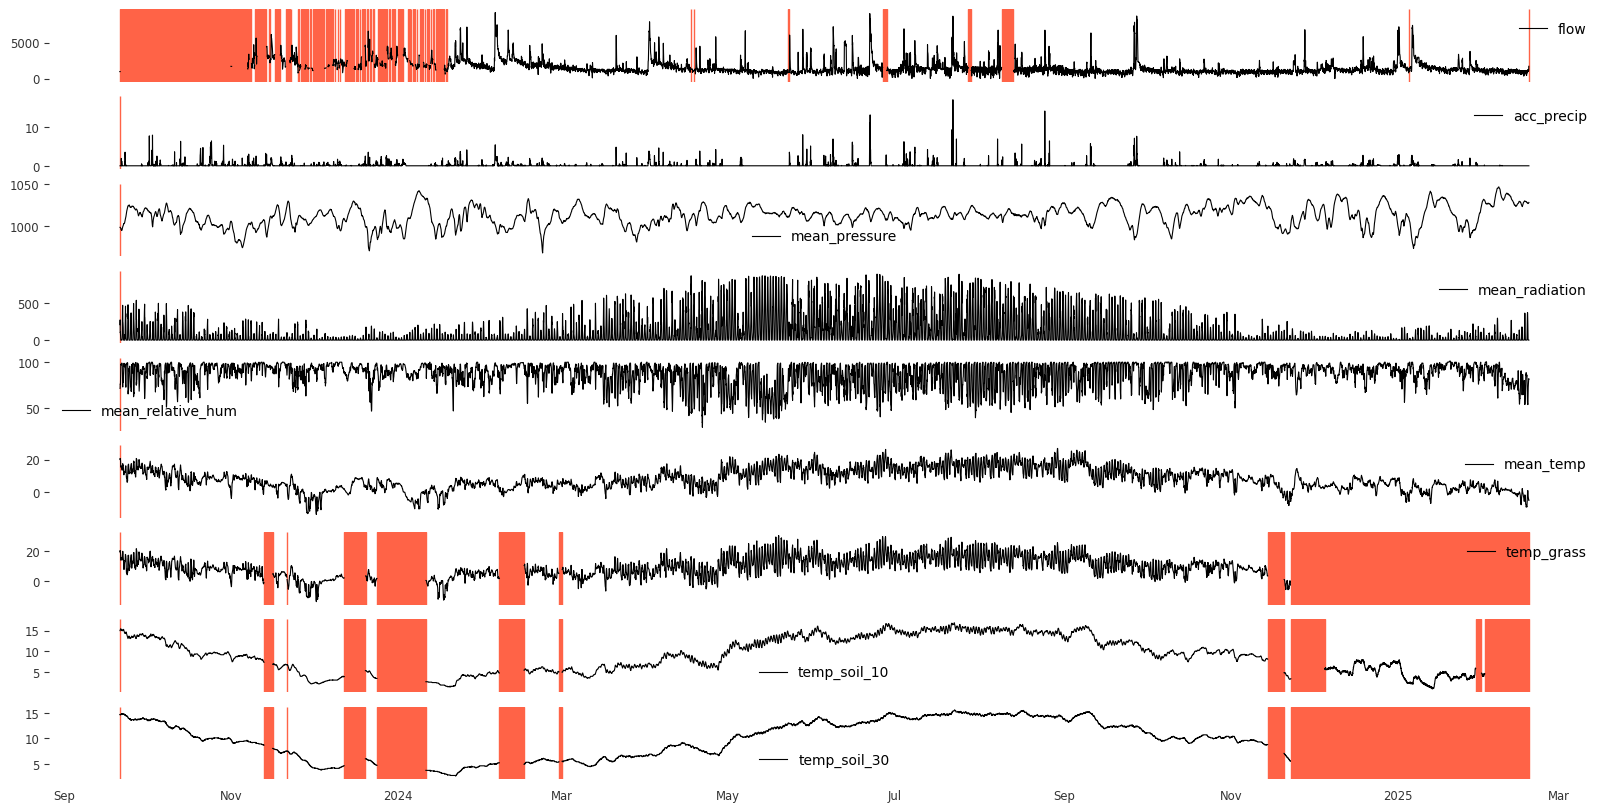

In [9]:
fig, axes = plt.subplots(ts.n_components, 1, figsize=(20, 10), sharex="col")

for i, component in enumerate(ts.components):
    gaps = ts[component].gaps(mode="any")
    ts[component].plot(ax=axes[i], linewidth=0.8)
    for _, row in gaps.iterrows():
        axes[i].axvspan(xmin=row["gap_start"], xmax=row["gap_end"], color="tomato")
    axes[i].grid(visible=False)
    axes[i].set_xlabel("")

- Saving data after merging

In [10]:
ts.to_csv(path_to_merged_data)

## Trends

(Each trend line corresponds to one continuouts subseries)


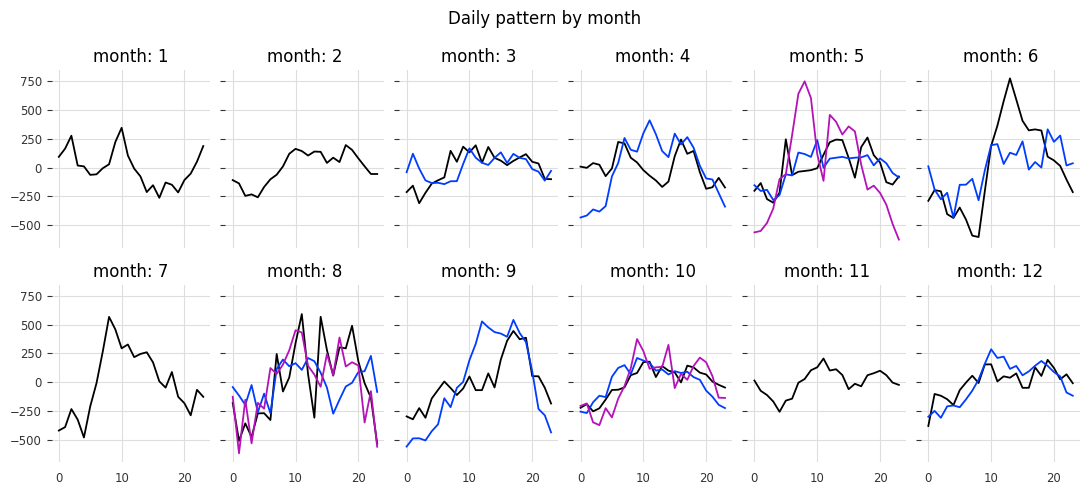

In [11]:
df = data[["flow"]].copy()
df = df.loc[df.index.year == 2024, :].copy()

ncols = 6
fig, axes = plt.subplots(2, ncols, sharex=True, sharey=True, figsize=(11, 5))

month = 1
for i, month in enumerate(range(1, 13)):
    df_i = df.loc[df.index.month == month, :]
    df_i.index = df_i.index.tz_localize(
        None
    )  # this is done to avoid a warning message from darts
    ts_i = TimeSeries.from_dataframe(df_i, freq="h")
    subseries = extract_subseries(ts_i)
    for ssi in subseries:
        if len(ssi) > 72:
            trend_i, seasonality_i = extract_trend_and_seasonality(
                ssi, freq=24, model=ModelMode.ADDITIVE
            )
            daily_pattern = (
                seasonality_i.to_dataframe()
                .groupby(seasonality_i.time_index.hour)
                .mean()
            )

            row = i // ncols
            col = i - row * ncols
            axes[row, col].plot(daily_pattern.index, daily_pattern.values.ravel())
            axes[row, col].set_title(f"month: {month}")

plt.suptitle("Daily pattern by month")
plt.tight_layout()

print("(Each trend line corresponds to one continuouts subseries)")

## Correlations

In [27]:
data.corr().style.background_gradient(cmap="coolwarm").format(precision=3)

,flow,acc_precip,mean_pressure,mean_radiation,mean_relative_hum,mean_temp,temp_grass,temp_soil_10,temp_soil_30
flow,1.000,0.589,-0.389,-0.055,0.117,-0.065,-0.035,-0.143,-0.169
acc_precip,0.589,1.000,-0.187,-0.076,0.147,0.037,0.031,0.025,0.014
mean_pressure,-0.389,-0.187,1.000,0.081,-0.085,0.004,0.114,0.118,0.175
mean_radiation,-0.055,-0.076,0.081,1.000,-0.698,0.548,0.653,0.336,0.277
mean_relative_hum,0.117,0.147,-0.085,-0.698,1.000,-0.407,-0.501,-0.205,-0.125
mean_temp,-0.065,0.037,0.004,0.548,-0.407,1.000,0.973,0.832,0.758
temp_grass,-0.035,0.031,0.114,0.653,-0.501,0.973,1.000,0.758,0.703
temp_soil_10,-0.143,0.025,0.118,0.336,-0.205,0.832,0.758,1.000,0.985
temp_soil_30,-0.169,0.014,0.175,0.277,-0.125,0.758,0.703,0.985,1.000


We expect the precipitation to be correlated with the inflow. However, the dynamics of both series will differ as the WWTP has a limited capacity to take rain water in. In order to analyze this effect, we smooth the the precipitation time series using a Holt low pass filter and evaluate the change of correlation.

In addition, we lag the time series to investigate if there xist a lagged effect.

In [26]:
def f(x: float, ts: TimeSeries, lag: int):
    time_index = ts.time_index
    filtered_precip = pd.Series(
        holt_smoother(ts["acc_precip"].values().ravel(), x), index=time_index
    )
    x1 = filtered_precip.shift(lag).dropna()
    x2 = ts["flow"].to_series().loc[x1.index]

    return -np.abs(pearsonr(x1.values, x2.values).statistic)


ts = TimeSeries.from_dataframe(
    data[["flow", "acc_precip"]], freq="h"
).longest_contiguous_slice(mode="any")


for lag in [0, 1, 2, 3, 4]:
    res = minimize_scalar(f, bounds=(1e-5, 0.9999), args=(ts, lag))
    print(lag, round(res.fun, 3), round(res.x, 3))

0 -0.845 0.156
1 -0.8 0.167
2 -0.746 0.122
3 -0.699 0.096
4 -0.661 0.082


Notice that correlation has increased from 0.589 to 0.845 after the smoothing. Finally, we observe that the correlation is maximum when there is no delay between precipitation and inflow series.

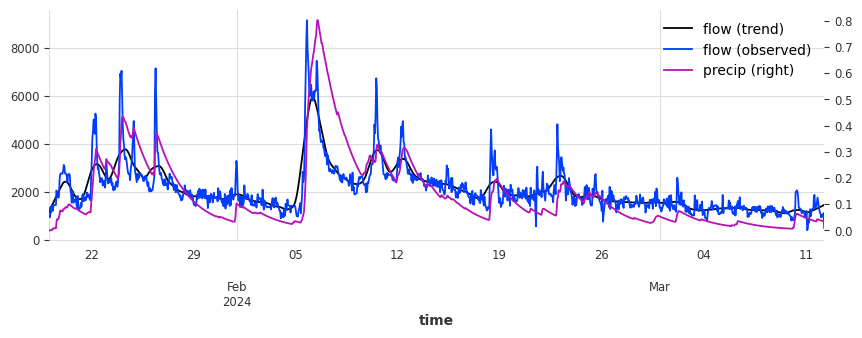

In [25]:
trend, seasonality = extract_trend_and_seasonality(
    ts["flow"], model=ModelMode.ADDITIVE, method="STL"
)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
pd.DataFrame(
    {
        "flow (trend)": trend.values().ravel(),
        "flow (observed)": ts["flow"].values().ravel(),
        "precip": holt_smoother(ts["acc_precip"].values().ravel(), 0.02),
    },
    index=ts.time_index,
).plot(ax=ax, secondary_y="precip");

We would like to compare the correlation with data from the summer. We can look for the longest subseries that contains summer dates:

In [30]:
df = data.loc[:, ["flow", "acc_precip", "mean_temp", "mean_radiation"]].copy()

subseries = extract_subseries(
    TimeSeries.from_dataframe(
        df,
        freq="h",
    ),
    mode="any",
)

subseries = [ssi for ssi in subseries if len(ssi) > 24 * 14]

results = []
for i, ssi in enumerate(subseries):
    # We only optimize for periods with different precipitation measurements
    if len(set(ssi["acc_precip"].values().ravel())) > 1:
        mean_temp = ssi["mean_temp"].to_series().mean()
        mean_radiation = ssi["mean_radiation"].to_series().mean()

        res = minimize_scalar(f, bounds=(1e-3, 0.999), args=(ssi, 0))

        results.append((res.x, mean_temp, mean_radiation))

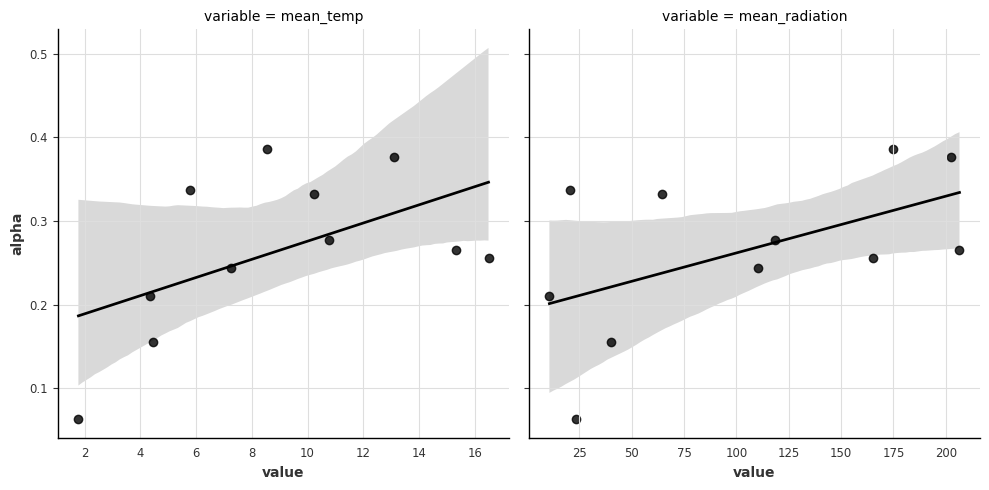

In [31]:
datplot = pd.DataFrame(results, columns=["alpha", "mean_temp", "mean_radiation"]).melt(
    id_vars="alpha"
)
sns.lmplot(
    datplot, x="value", y="alpha", col="variable", order=1, facet_kws=dict(sharex=False)
);

The previous figure suggests that during periods of high temperature and radiation, the correlation between flow and precipitation reaches its maximum after the precipitation series has been more smoothed compared to periods of low temperature and radiation.